### Variational Graph Auto-Encoder for DTI

In [2]:
from __future__ import division
from __future__ import print_function

import os
import time
import pickle

import numpy as np
import scipy.sparse as sp

import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt

# from plotly.offline import init_notebook_mode, iplot
# from IPython.display import display, HTML

# init_notebook_mode(connected=False)

from datetime import datetime
from collections import namedtuple
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

**Utility functions**

In [3]:
def secs_to_mins(secs):
    mins = int(secs / 60)
    secs = int(secs % 60)
    
    if mins != 0:
        time_in_mins = str(mins) + "m " + str(secs) + "s"
    else:
        time_in_mins = str(secs) + "s"
        
    return time_in_mins

def build_tensorboard_dir():
    dir_name = str(datetime.now())
    dir_path = 'data/tensorboard/' + dir_name
    
    assert not os.path.exists(dir_path), 'Path already exists.'
    os.makedirs(dir_path)

def load_data():
    g = nx.read_edgelist('yeast.edgelist')
    adj = nx.adjacency_matrix(g)
    return adj

def glorot(shape, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform(
        [input_dim, output_dim], minval=-init_range,
        maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def dropout_sparse(x, keep_prob, num_nonzero_elems):
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1. / keep_prob)

def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)

def construct_feed_dict(adj_normalized, adj, features, placeholders):
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict

def mask_test_edges(adj):
    # Function to build test set with 2% positive links
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 50.))
    num_val = int(np.floor(edges.shape[0] / 50.))

    all_edge_idx = range(edges.shape[0])
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b):
        rows_close = np.all((a - b[:, None]) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        n_rnd = len(test_edges) - len(test_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], edges_all):
                continue
            if test_edges_false:
                if ismember([idx_j, idx_i], np.array(test_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(test_edges_false)):
                    continue
            test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        n_rnd = len(val_edges) - len(val_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], train_edges):
                continue
            if ismember([idx_j, idx_i], train_edges):
                continue
            if ismember([idx_i, idx_j], val_edges):
                continue
            if ismember([idx_j, idx_i], val_edges):
                continue
            if val_edges_false:
                if ismember([idx_j, idx_i], np.array(val_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(val_edges_false)):
                    continue
            val_edges_false.append([idx_i, idx_j])

    # Re-build adj matrix
    data = np.ones(train_edges.shape[0])
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false


def get_roc_score(edges_pos, edges_neg):
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

**Layer Definitions**

In [4]:
class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).

    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.summary.histogram(self.name + '/vars/' + var, self.vars[var])


class GraphConvolution():
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, name, dropout=0., act=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.act = act

    def __call__(self, inputs):
        with tf.name_scope(self.name):        
            x = inputs
            x = tf.nn.dropout(x, 1-self.dropout)
            x = tf.matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.act(x)
        return outputs


class GraphConvolutionSparse():
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, name, dropout=0., act=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = True
        self.features_nonzero = features_nonzero

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            x = inputs
            x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
            x = tf.sparse_tensor_dense_matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.act(x)
        return outputs
    
def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res
    
class Dense(Layer):
    """Dense layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0., sparse_inputs=False,
                 act=tf.nn.relu, bias=False, featureless=False, **kwargs):
        super(Dense, self).__init__(**kwargs)

        if dropout is not None:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim,
                                          name='weights')
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # transform
        output = dot(x, self.vars['weights'], sparse=self.sparse_inputs)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)
    
class InnerProductDecoder():
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, name, dropout=0., act=tf.nn.sigmoid):
        self.name = name
        self.issparse = False
        self.dropout = dropout
        self.act = act

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            inputs = tf.nn.dropout(inputs, 1-self.dropout)
            x = tf.transpose(inputs)
            x = tf.matmul(inputs, x)
            x = tf.reshape(x, [-1])
            outputs = self.act(x)
        return outputs

**Loading Data**

In [5]:
with open('data/dti_store/graph_2.pkl') as f:
    graph = pickle.load(f)
    
u_nodes, v_nodes, ratings = graph[2], graph[3], graph[4]
g = np.vstack([u_nodes, v_nodes, ratings])

g = g.T
g = g[g[:, 2].argsort()]
g_0, g_1 = np.split(g, np.where(np.diff(g[:,2]))[0]+1)

graph_pos = g_1
graph_pos = graph_pos.T

x, y, _ = graph_pos

x = x.reshape((1, x.shape[0]))
y = y.reshape((1, y.shape[0]))
graph_pos = np.concatenate([x, y], axis=0)

graph_pos = graph_pos.T

for i in range(len(graph_pos)):
    graph_pos[i][1] += 1861
    
adj = list()
for s, d in graph_pos:
    adj.append((s, d))
    
G = nx.Graph(adj)
adj = nx.adj_matrix(G)

num_nodes = adj.shape[0]
num_edges = adj.sum()

# # Featureless
u_feat = np.array(graph[5].todense())
v_feat = np.array(graph[6].todense())

padded_v = tf.keras.preprocessing.sequence.pad_sequences(v_feat, maxlen=u_feat.shape[1], dtype='float32', padding='post', truncating='post')
features = np.concatenate([u_feat, padded_v], axis=0)
# features = tf.keras.preprocessing.sequence.pad_sequences(features, maxlen=u_feat.shape[0] + v_feat.shape[0], dtype='int64', padding='post', truncating='post')
features = features[:-1,:-1]

features = sp.csr_matrix(features)

features = sparse_to_tuple(features)
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

adj_norm = preprocess_graph(adj)

**Hyperparameters**

In [6]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Learning rate
learning_rate = 0.001

# Layer sizes
hidden1 = 512
hidden2 = 256
hidden3 = 128
hidden4 = 64
hidden5 = 32
hidden6 = 64

# drop_prob
dropout = 0.1

In [13]:
validation_auroc_readings = []

**Building the model**

In [50]:
class VariationalGraphAutoEncoder:
    
    def __init__(self, placeholders, num_features, features_nonzero, num_nodes, name):
        """ Class for modelling a Variational graph auto-encoder. """
        
        self.name = name
        self.placeholders = placeholders
        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        self.n_samples = num_nodes
        with tf.variable_scope(self.name):
            self.build()
        
    def build(self):
        """ Build the architecture. """
        
        # Set random seed
        seed = 1324
        np.random.seed(seed)
        tf.set_random_seed(seed)

        # Learning rate
        learning_rate = 0.001

        # Layer sizes
        hidden1 = 512
        hidden2 = 256
        hidden3 = 128
        hidden4 = 64
        hidden5 = 32
        hidden6 = 64

        # drop_prob
        dropout = 0.1
        
        self.hidden1 = GraphConvolutionSparse(
            name='vgae_graph_conv_sparse_1',
            input_dim=self.input_dim,
            output_dim=hidden1,
            adj=self.adj,
            features_nonzero=self.features_nonzero,
            act=tf.nn.relu,
            dropout=self.dropout)(self.inputs)
                
        self.z_mean = GraphConvolution(
            name='mean_layer',
            input_dim=hidden1,
            output_dim=hidden2,
            adj=self.adj,
            act=lambda x: x,
            dropout=self.dropout)(self.hidden1)

        self.z_log_std = GraphConvolution(
            name='std_dev_layer',
            input_dim=hidden1,
            output_dim=hidden2,
            adj=self.adj,
            act=lambda x: x,
            dropout=self.dropout)(self.hidden1)

        self.embeddings = self.z_mean + tf.random_normal([self.n_samples, hidden2]) * tf.exp(self.z_log_std)
        
#         self.hidden2 = GraphConvolution(
#             name='vgae_graph_conv_1',
#             input_dim=hidden1,
#             output_dim=hidden2,
#             adj=self.adj,
#             act=tf.nn.relu,
#             dropout=self.dropout)(self.hidden1)
        
#         self.hidden3 = Dense(
#             name='vgae_dense_1',
#             input_dim=hidden2,
#             output_dim=hidden3,
#             placeholders=self.placeholders,
#             act=tf.nn.relu,
#             dropout=self.dropout)(self.z)
        
#         self.hidden4 = Dense(
#             name='vgae_dense_2',
#             input_dim=hidden3,
#             output_dim=hidden4,
#             placeholders=self.placeholders,
#             act=tf.nn.relu,
#             dropout=self.dropout)(self.hidden3)

#         self.embeddings = Dense(
#             name='vgae_dense_3',
#             input_dim=hidden4,
#             output_dim=hidden5,
#             placeholders=self.placeholders,
#             act=lambda x: x,
#             dropout=self.dropout)(self.hidden4)
    
        self.hidden5 = Dense(
            name='vgae_dense_4',
            input_dim=hidden2,
            output_dim=hidden3,
            placeholders=self.placeholders,
            act=lambda x: x,
            dropout=self.dropout)(self.embeddings)
        
        self.reconstructions = InnerProductDecoder(
            name='vgae_inner_product_1',
            input_dim=hidden3,
            act=lambda x: x)(self.hidden5)

In [51]:
class Optimizer():
    
    def __init__(self, preds, labels, num_nodes, num_edges):
        """ Defines optimizer class for the VGAE model. """
        
        pos_weight = float(num_nodes**2) / num_edges
        norm = num_nodes**2 / float((num_nodes**2 - num_edges) * 2)
        
        preds_sub = preds
        labels_sub = labels
        
        self.cost = norm * tf.reduce_mean(
            tf.nn.weighted_cross_entropy_with_logits(
                logits=preds_sub, targets=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        
        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

In [52]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)
}

# Create model
model = VariationalGraphAutoEncoder(placeholders, num_features, features_nonzero, adj.shape[0], name='dti_gcn')

# Create optimizer
with tf.name_scope('optimizer'):
    opt = Optimizer(
        preds=model.reconstructions,
        labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'], validate_indices=False), [-1]),
        num_nodes=num_nodes,
        num_edges=num_edges)

**Training**

In [53]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

best_test_roc = 0.
best_roc_iter = 0
best_test_ap = 0.
best_ap_iter = 0

epochs = 200
early_stopping = False
is_early_stopping = False
patience = 25
init_time = time.time()

val_rocs = []

# Train model
for epoch in range(epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: dropout})
    # One update of parameter matrices
    _, avg_cost = sess.run([opt.opt_op, opt.cost], feed_dict=feed_dict)
    # Performance on validation set
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    roc_test, ap_test = get_roc_score(test_edges, test_edges_false)
    
    val_rocs.append(roc_curr)
    
    if best_test_roc < roc_test:
        best_test_roc = roc_test
        best_roc_iter = epoch
    
    if best_test_ap < ap_test:
        best_test_ap = ap_test
        best_ap_iter = epoch
        
    if early_stopping:
        if epoch - best_roc_iter > patience:
            is_early_stopping = True
            break
    
    print("Epoch:", '%04d' % (epoch + 1),
          "train_loss=", "{:.5f}".format(avg_cost),
          "val_roc=", "{:.5f}".format(roc_curr),
          "val_ap=", "{:.5f}".format(ap_curr),
          "test_roc=", "{:.5f}".format(roc_test),
          "ap_test=", "{:.5f}".format(ap_test),
          "time=", "{:.5f}".format(time.time() - t))

print()
print('Optimization Finished!')
if is_early_stopping:
    print ("Stopped by Early Stopping method.")
print()

roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Final Test ROC score: {:.5f}'.format(roc_score))
print('Final Test AP score: {:.5f}'.format(ap_score))
print('Time taken: ' + secs_to_mins(time.time() - init_time))
print()

print('Best test ROC: {:.5f}'.format(best_test_roc), 'at iteration', best_roc_iter)
print('Best test AP: {:.5f}'.format(best_test_ap), 'at iteration', best_ap_iter)

Epoch: 0001 train_loss= 8.28216 val_roc= 0.58952 val_ap= 0.57473 test_roc= 0.60683 ap_test= 0.58514 time= 2.90656
Epoch: 0002 train_loss= 6.81621 val_roc= 0.62288 val_ap= 0.63288 test_roc= 0.61350 ap_test= 0.63742 time= 1.35214
Epoch: 0003 train_loss= 5.97853 val_roc= 0.65734 val_ap= 0.70831 test_roc= 0.67307 ap_test= 0.70648 time= 1.34348
Epoch: 0004 train_loss= 5.13572 val_roc= 0.62717 val_ap= 0.69337 test_roc= 0.64095 ap_test= 0.70498 time= 1.34891
Epoch: 0005 train_loss= 4.36431 val_roc= 0.66439 val_ap= 0.73007 test_roc= 0.66265 ap_test= 0.72330 time= 1.35559
Epoch: 0006 train_loss= 3.54903 val_roc= 0.65191 val_ap= 0.71795 test_roc= 0.67828 ap_test= 0.73706 time= 1.34926
Epoch: 0007 train_loss= 2.94390 val_roc= 0.68349 val_ap= 0.74889 test_roc= 0.68755 ap_test= 0.74399 time= 1.34498
Epoch: 0008 train_loss= 2.42766 val_roc= 0.72656 val_ap= 0.74698 test_roc= 0.68007 ap_test= 0.72087 time= 1.36159
Epoch: 0009 train_loss= 2.06091 val_roc= 0.68012 val_ap= 0.71898 test_roc= 0.66558 ap_te

Epoch: 0073 train_loss= 0.55325 val_roc= 0.82585 val_ap= 0.85839 test_roc= 0.82813 ap_test= 0.84910 time= 1.37874
Epoch: 0074 train_loss= 0.56300 val_roc= 0.82281 val_ap= 0.86050 test_roc= 0.77452 ap_test= 0.81831 time= 1.37013
Epoch: 0075 train_loss= 0.55777 val_roc= 0.83930 val_ap= 0.84888 test_roc= 0.81283 ap_test= 0.83165 time= 1.37749
Epoch: 0076 train_loss= 0.56035 val_roc= 0.83095 val_ap= 0.87155 test_roc= 0.79080 ap_test= 0.82898 time= 1.36433
Epoch: 0077 train_loss= 0.54810 val_roc= 0.83713 val_ap= 0.86512 test_roc= 0.79731 ap_test= 0.81319 time= 1.37364
Epoch: 0078 train_loss= 0.55879 val_roc= 0.83301 val_ap= 0.86298 test_roc= 0.76953 ap_test= 0.80824 time= 1.41490
Epoch: 0079 train_loss= 0.55429 val_roc= 0.83409 val_ap= 0.85156 test_roc= 0.82444 ap_test= 0.84758 time= 1.37033
Epoch: 0080 train_loss= 0.54723 val_roc= 0.82834 val_ap= 0.87010 test_roc= 0.80881 ap_test= 0.83918 time= 1.35804
Epoch: 0081 train_loss= 0.55154 val_roc= 0.85243 val_ap= 0.88868 test_roc= 0.79915 ap_te

Epoch: 0145 train_loss= 0.47799 val_roc= 0.88889 val_ap= 0.91714 test_roc= 0.83073 ap_test= 0.87138 time= 1.56184
Epoch: 0146 train_loss= 0.47799 val_roc= 0.87055 val_ap= 0.90571 test_roc= 0.84256 ap_test= 0.86624 time= 1.36762
Epoch: 0147 train_loss= 0.47832 val_roc= 0.88357 val_ap= 0.91489 test_roc= 0.84473 ap_test= 0.86123 time= 1.38257
Epoch: 0148 train_loss= 0.47538 val_roc= 0.90180 val_ap= 0.92843 test_roc= 0.86502 ap_test= 0.87427 time= 1.38783
Epoch: 0149 train_loss= 0.47804 val_roc= 0.88770 val_ap= 0.91396 test_roc= 0.83908 ap_test= 0.87194 time= 1.36815
Epoch: 0150 train_loss= 0.47224 val_roc= 0.87294 val_ap= 0.88920 test_roc= 0.85786 ap_test= 0.88706 time= 1.37889
Epoch: 0151 train_loss= 0.47462 val_roc= 0.87305 val_ap= 0.91354 test_roc= 0.83735 ap_test= 0.86985 time= 1.34947
Epoch: 0152 train_loss= 0.47387 val_roc= 0.88270 val_ap= 0.91584 test_roc= 0.83930 ap_test= 0.87070 time= 1.36986
Epoch: 0153 train_loss= 0.46881 val_roc= 0.86686 val_ap= 0.90720 test_roc= 0.83789 ap_te

In [55]:
val_rocs = np.array(val_rocs)
epochs = np.arange(0., len(val_rocs), 1.)

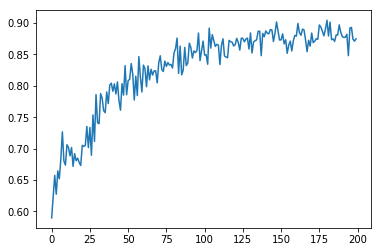

In [56]:
plt.plot(epochs, val_rocs)
plt.show()

In [57]:
validation_auroc_readings.append(val_rocs)

In [58]:
validation_auroc_readings

[array([0.47591146, 0.56141493, 0.63487413, 0.61328125, 0.60134549,
        0.6110026 , 0.60959201, 0.59874132, 0.54383681, 0.54134115,
        0.5327691 , 0.5609809 , 0.52148438, 0.54953342, 0.49734158,
        0.54079861, 0.59809028, 0.63650174, 0.65722656, 0.68088108,
        0.60177951, 0.65332031, 0.60232205, 0.62196181, 0.59233941,
        0.69737413, 0.65972222, 0.66818576, 0.63302951, 0.63682726,
        0.64322917, 0.6703559 , 0.63226997, 0.61924913, 0.67198351,
        0.63085938, 0.68272569, 0.66861979, 0.67664931, 0.65983073,
        0.68500434, 0.6500651 , 0.69184028, 0.65896267, 0.69422743,
        0.6890191 , 0.71571181, 0.6984592 , 0.66297743, 0.71527778,
        0.70844184, 0.68630642, 0.69357639, 0.70214844, 0.73014323,
        0.71907552, 0.69639757, 0.6859809 , 0.69542101, 0.70062934,
        0.72927517, 0.7358941 , 0.71614583, 0.74012587, 0.72135417,
        0.69401042, 0.7046441 , 0.70019531, 0.67361111, 0.70562066,
        0.73394097, 0.71940104, 0.75130208, 0.71

In [59]:
names.append('scr2')